In [150]:
pip install lightkurve 

Note: you may need to restart the kernel to use updated packages.


In [151]:
pip install astropy

Note: you may need to restart the kernel to use updated packages.


In [152]:
# Import the necessary library
import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt

In [153]:
# Define the TIC ID and sector number
tic_id = '  307210830      '
sector_id = 39 # Example sector ID

# Search and download the light curve data for the specified TIC ID and sector
search_result = lk.search_lightcurve(f'TIC {tic_id}', mission='TESS', sector=sector_id, exptime=120, author='SPOC')
lc = search_result.download()
lc = lc.normalize()
lc= lc.remove_outliers(sigma=6) # clip the light curve to remove deviant datapoints greater than 6 sigma

# Check if the light curve data is loaded successfully
if lc is not None:
    print("Light curve data loaded successfully.")
else:
    print(f"No light curve data available for TIC {tic_id} in sector {sector_id}.")


Light curve data loaded successfully.


In [154]:
#Lightkurves / Flatten / Phase Fold / Zoom in 

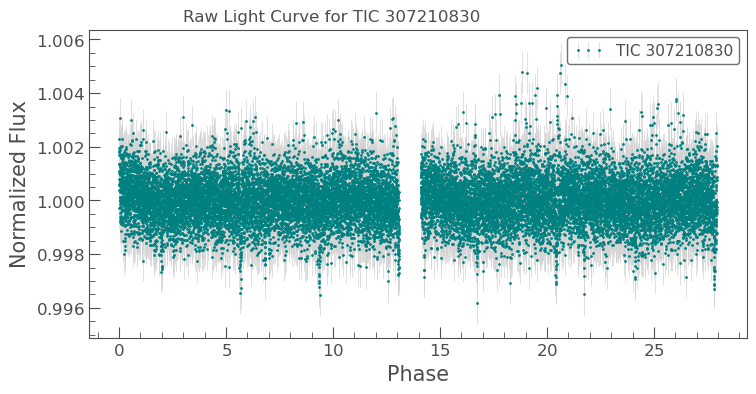

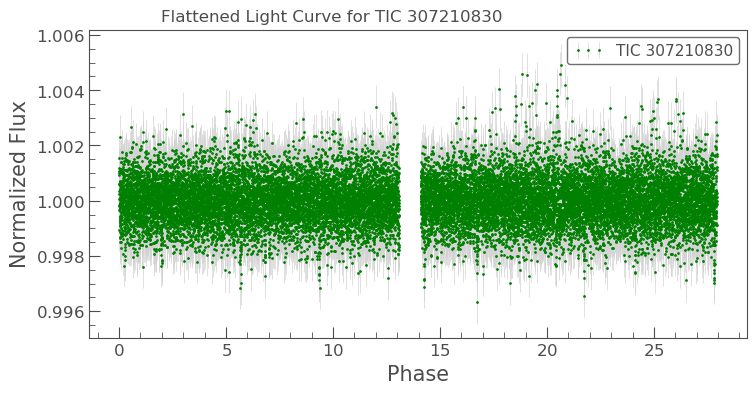

In [155]:
# Check if the light curve data exists
if lc is not None:
    # Adjust the time values to start from zero
    lc['time'] = lc['time'].mjd - lc[0]['time'].mjd

    # Plot the adjusted light curve
    lc.errorbar(fmt='.', ecolor='LightGrey', color='teal')
    plt.xlabel('Phase')
    plt.ylabel('Normalized Flux')
    plt.title(f'Raw Light Curve for TIC {tic_id}')
    plt.show()
    
    # Flatten the light curve to remove long-term trends
    flat_lc = lc.flatten(window_length=401)
    flat_lc.errorbar(fmt='.', ecolor='LightGrey', color='green') 
    plt.xlabel('Phase')
    plt.ylabel('Normalized Flux')
    plt.title(f'Flattened Light Curve for TIC {tic_id}')
    plt.show()
else:
    print(f"No light curve data available for TIC {tic_id}")

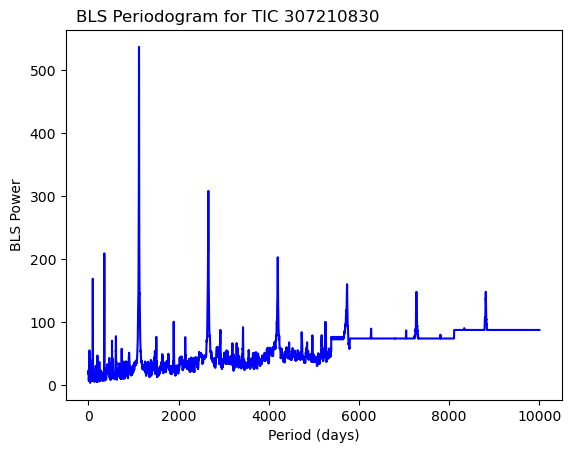

In [156]:
period = np.linspace(1, 25, 10000)  # searching for periods from 1 to 20 days
bls = lc.to_periodogram('bls', period=period, frequency_factor=1000)

# Plotting the BLS periodogram
plt.plot(bls.power, color='blue')
plt.xlabel('Period (days)')
plt.ylabel('BLS Power')
plt.title(f'BLS Periodogram for TIC {tic_id}')
plt.show()


3.690669066906691 d 1.9849999999999999 0.05 d 0.0015142927231992823


C:\Users\deang\anaconda3\New folder\Lib\site-packages\astropy\utils\decorators.py:604: LightkurveDeprecationWarning: "t0" was deprecated in version 2.0 and will be removed in a future version. Use argument "epoch_time" instead.
  return function(*args, **kwargs)


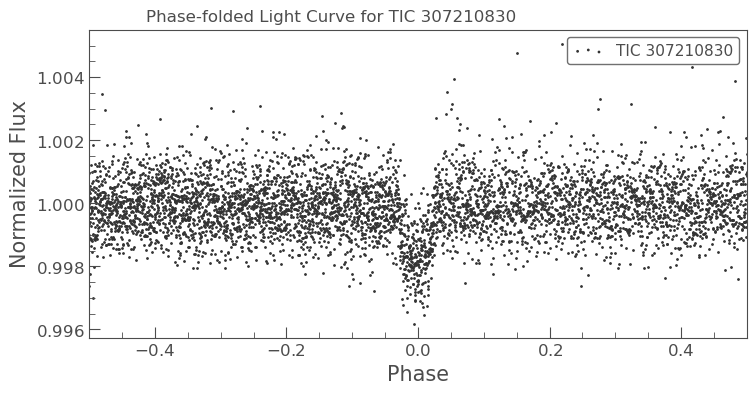

In [157]:
# Use a BLS periodogram to find the period
planet_c_period = bls.period_at_max_power
planet_c_t0 = bls.transit_time_at_max_power
planet_c_dur = bls.duration_at_max_power
planet_c_dep = bls.depth_at_max_power 
# Check the value for period and t0
print(planet_c_period, planet_c_t0, planet_c_dur,planet_c_dep )
    
# Fold the light curve at the identified period and t0, then plot
ax = lc.fold(period=planet_c_period.value, t0=planet_c_t0).scatter()
ax.set_xlim(-0.5, 0.5)  # Setting x-axis limits to zoom in around the transit event

plt.xlabel('Phase')
plt.ylabel('Normalized Flux')
plt.title(f'Phase-folded Light Curve for TIC {tic_id}')
plt.show()



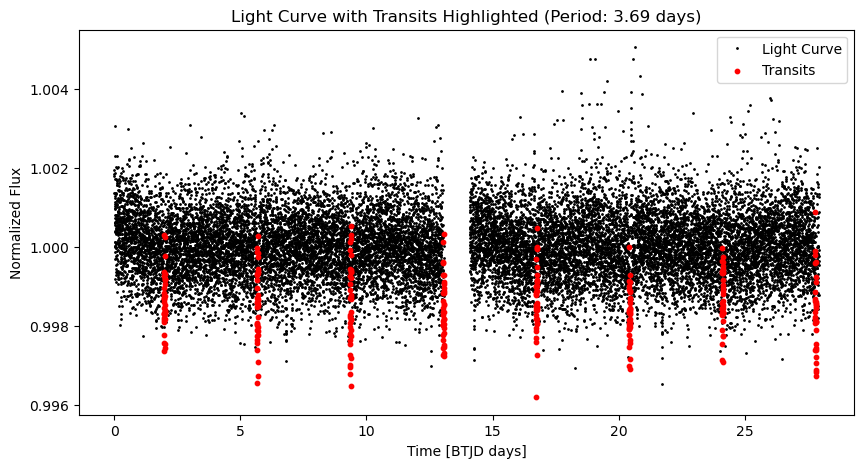

<Figure size 1000x500 with 0 Axes>

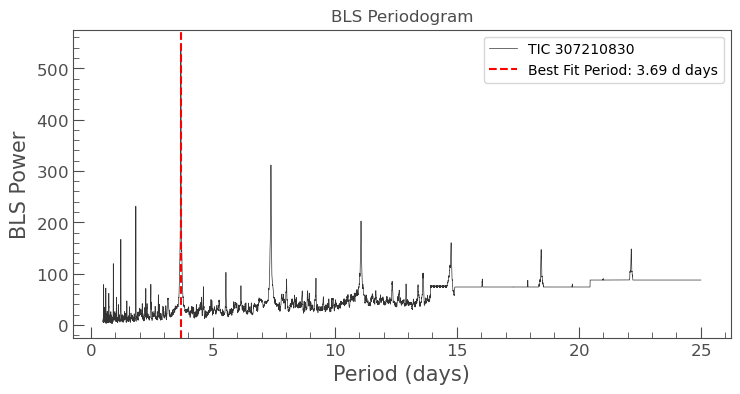

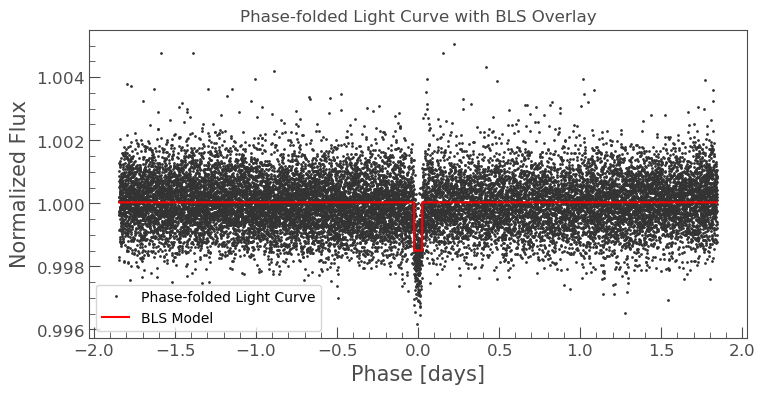

In [158]:
# Assuming you already have the light curve data in `lc` and have performed BLS which gives you `best_fit_period` and `best_fit_t0`
# Perform BLS Analysis to find the best fit period and epoch
bls_results = lc.to_periodogram(method='bls', period=np.linspace(0.5, 25, 10000))
best_fit_period = bls_results.period_at_max_power
best_fit_t0 = bls_results.transit_time_at_max_power

# Highlight the transits on the light curve
transit_mask = bls_results.get_transit_mask(period=best_fit_period, transit_time=best_fit_t0, duration=bls_results.duration_at_max_power)
plt.figure(figsize=(10, 5))  # Set the figure size as desired
plt.plot(lc.time.value, lc.flux, 'k.', label='Light Curve', linestyle='none', markersize=2)
plt.scatter(lc.time.value[transit_mask], lc.flux[transit_mask], color='red', label='Transits', zorder=2, s=10)
plt.legend()
plt.xlabel('Time [BTJD days]')
plt.ylabel('Normalized Flux')
plt.title(f'Light Curve with Transits Highlighted (Period: {best_fit_period.value:.2f} days)')
plt.show()

# Plot the BLS periodogram with the highest power point indicated
plt.figure(figsize=(10, 5))
bls_results.plot()
plt.axvline(x=best_fit_period.value, color='r', linestyle='--', label=f'Best Fit Period: {best_fit_period:.2f} days')
plt.xlabel('Period (days)')
plt.ylabel('BLS Power')
plt.title('BLS Periodogram')
plt.legend()
plt.show()

# Plot the original phase-folded light curve with BLS model overlaid
folded_lc = lc.fold(period=best_fit_period.value, epoch_time=best_fit_t0.value)
bls_model = bls_results.get_transit_model(period=best_fit_period, transit_time=best_fit_t0, duration=bls_results.duration_at_max_power)
folded_lc.plot(label='Phase-folded Light Curve', marker='.', linestyle='none')
plt.plot(folded_lc.time.value, bls_model.fold(period=best_fit_period, epoch_time=best_fit_t0).flux, color='red', label='BLS Model')
plt.legend()
plt.xlabel('Phase [days]')
plt.ylabel('Normalized Flux')
plt.title('Phase-folded Light Curve with BLS Overlay')
plt.show()


In [159]:
flattened_lc.interact_bls()

In [160]:
pip install astroquery


Note: you may need to restart the kernel to use updated packages.


In [161]:
from astroquery.mast import Catalogs

# Clean up the TIC ID and query the TIC catalog
tic_id_cleaned = tic_id.strip()
catalogData = Catalogs.query_criteria(catalog="TIC", ID=tic_id_cleaned)

# Extract and print the star's parameters
print(f"Star's Name: {catalogData['ID'][0]}")
print(f"Radius (Rs): {catalogData['rad'][0]:.2f} ± {catalogData['e_rad'][0]:.2f} Solar radii")
print(f"Mass (Ms): {catalogData['mass'][0]:.2f} ± {catalogData['e_mass'][0]:.2f} Solar masses")
print(f"Metallicity [Fe/H]: {catalogData['MH'][0]:.2f} ± {catalogData['e_MH'][0]:.2f}")
print(f"Surface Gravity log(g): {catalogData['logg'][0]:.2f} ± {catalogData['e_logg'][0]:.2f}")
print(f"Effective Temperature (Teff): {catalogData['Teff'][0]:.0f} ± {catalogData['e_Teff'][0]:.0f} K")
print(f"V-band Magnitude: {catalogData['Tmag'][0]}")
print(f"K-band Magnitude: {catalogData['Kmag'][0]}")
print(f"Right Ascension (RA): {catalogData['ra'][0]}")
print(f"Declination (Dec): {catalogData['dec'][0]}")
print(f"Distance: {catalogData['d'][0]:.2f} ± {catalogData['e_d'][0]:.2f} parsecs")



Star's Name: 307210830
Radius (Rs): 0.31 ± 0.01 Solar radii
Mass (Ms): 0.29 ± 0.02 Solar masses
Metallicity [Fe/H]: nan ± nan
Surface Gravity log(g): 4.91 ± 0.00
Effective Temperature (Teff): 3429 ± 157 K
V-band Magnitude: 9.41242
K-band Magnitude: 7.101
Right Ascension (RA): 124.531756290083
Declination (Dec): -68.3129998725044
Distance: 10.62 ± 0.00 parsecs


In [162]:
# Find the out-of-transit baseline flux level (assuming it's around the median of the out-of-transit data)
baseline_flux = np.median(folded_lc.flux[~transit_mask])

# Find the flux at the minimum point of the transit (deepest part of the dip)
transit_flux = np.min(folded_lc.flux[transit_mask])

# Calculate the transit depth
transit_depth = (baseline_flux - transit_flux) / baseline_flux

# Express the transit depth in percentage
transit_depth_pct = transit_depth * 100

# Print the transit depth
print(f"Transit depth: {transit_depth_pct:.3f}%")


Transit depth: 0.228%


In [163]:
from astropy.constants import R_sun
import numpy as np

# This assumes you've already got 'bls_results' from the light curve analysis.
transit_depth = transit_depth_pct  # Replace with your actual BLS result

# Assuming 'catalogData' is the result from the TIC catalog query.
star_radius_sol = catalogData['rad'][0]  # Star radius in solar radii
star_radius_error = catalogData['e_rad'][0]  # Error in star radius

# Convert star radius from solar radii to meters
star_radius_m = star_radius_sol * R_sun.value

# The transit depth is the square of the planet-to-star radius ratio
planet_radius_m = np.sqrt(transit_depth) * star_radius_m

# Convert the planet's radius from meters to Jupiter radii
planet_radius_rj = planet_radius_m / 69911e3  # Jupiter's mean radius in kilometers

# Print out the planet's radius to three decimal places
print(f"Estimated radius of the exoplanet: {planet_radius_rj:.3f} Jupiter radii")

# Propagate the error in the star's radius to estimate the error in the planet's radius
planet_radius_error = 0.5 * (transit_depth**-0.5) * star_radius_error / star_radius_sol * planet_radius_rj

# Print out the error in the planet's radius to three decimal places
print(f"Error in the exoplanet's radius: ±{planet_radius_error:.3f} Jupiter radii")



Estimated radius of the exoplanet: 1.492 Jupiter radii
Error in the exoplanet's radius: ±0.046 Jupiter radii


In [164]:
import numpy as np
import lightkurve as lk

# Define the number of bootstrap iterations
num_bootstrap_iterations = 10  # for example, you might need more

# Arrays to store the bootstrap results
bootstrap_periods = []
bootstrap_durations_hours = []  # Store durations in hours

# Conduct the bootstrap resampling
for i in range(num_bootstrap_iterations):
    # Randomly select data points with replacement to create a bootstrap sample
    indices = np.random.choice(len(lc.time.value), len(lc.time.value))
    bootstrap_lc = lk.LightCurve(time=lc.time.value[indices], flux=lc.flux.value[indices])

    # Perform BLS analysis on the resampled light curve
    bls_results_bootstrap = bootstrap_lc.to_periodogram(method='bls', period=np.linspace(0.5, 50, 10000))
    
    # Store the period from each bootstrap iteration
    bootstrap_periods.append(bls_results_bootstrap.period_at_max_power.value)
    
    # Store the duration in hours
    bootstrap_durations_hours.append(bls_results_bootstrap.duration_at_max_power.value * 24)  # Convert days to hours

# Calculate the standard deviations of the results as the uncertainties
period_error = np.std(bootstrap_periods)
duration_error_hours = np.std(bootstrap_durations_hours)  # Uncertainty in hours

# Report the results with calculated uncertainties
print(f"Period: {np.mean(bootstrap_periods):.6f} ± {period_error:.6f} days")
print(f"Transit Duration: {np.mean(bootstrap_durations_hours):.6f} ± {duration_error_hours:.6f} hours")


Period: 3.693069 ± 0.000000 days
Transit Duration: 1.200000 ± 0.000000 hours


In [165]:
period=20.382 


In [166]:
from astropy.constants import G, M_sun, au
from astropy import units as u

# Assuming these values are obtained from the BLS analysis or earlier steps
P = period * u.day  # Convert period to astropy Quantity in days
delta_P =  0 * u.day  # Convert period error to astropy Quantity in days

# Star's mass from the TIC catalog query, converted to astropy Quantity
M_star = catalogData['mass'][0] * u.M_sun
delta_M_star = catalogData['e_mass'][0] * u.M_sun

# Convert period and its error from days to seconds for the calculation
P = P.to(u.second)
delta_P = delta_P.to(u.second)

# Calculate the semi-major axis using Kepler's third law: a^3 = G * M_star * P^2 / (4 * pi^2)
a_cubed = (G * M_star * P**2) / (4 * np.pi**2)
a = a_cubed.cgs**(1/3)

# Convert a from cm to AU for better readability
a = a.to(u.AU)

# Propagate the uncertainties: (delta_a / a)^2 = (2 * delta_P / P)^2 + (delta_M_star / M_star)^2
fractional_delta_a = np.sqrt((2 * delta_P / P)**2 + (delta_M_star / M_star)**2)
delta_a = fractional_delta_a * a

# Let's assume 'a' and 'delta_a' are your final calculated values for the semi-major axis and its error.

# After all your calculations (outside any loop):
print(f"Semi-major axis: {a} AU")
print(f"Uncertainty in semi-major axis: {delta_a} AU")





Semi-major axis: 0.09697067131851077 AU AU
Uncertainty in semi-major axis: 0.0066719077667789705 AU AU


In [167]:
from astropy.constants import sigma_sb, au
from astropy import units as u

# Assuming you have the star's temperature (T_star) and radius (R_star) and their uncertainties
T_star = catalogData['Teff'][0] * u.K
T_star_error = catalogData['e_Teff'][0] * u.K
R_star = catalogData['rad'][0] * R_sun
R_star_error = catalogData['e_rad'][0] * R_sun

# Assuming a placeholder value for semi-major axis 'a' in AU and its error 'a_error'
#a = 0.05 * au  # Replace with your actual value for semi-major axis in astronomical units
#a_error = 0.001 * au  # Replace with your actual uncertainty in semi-major axis

# Assuming zero albedo for simplicity and full heat redistribution
albedo = 0

# Calculate the equilibrium temperature
T_eq = T_star * (np.sqrt(R_star / (2 * a)) * (1 - albedo)**0.25).decompose()

# Calculate the uncertainty in equilibrium temperature using error propagation
# The following propagation assumes the errors are small relative to the values
T_eq_error = T_eq * np.sqrt((T_star_error / T_star)**2 +
                            (0.5 * R_star_error / R_star)**2 +
                            (0.5 * delta_a / a)**2)

# Print the equilibrium temperature with its error
print(f"Planetary equilibrium temperature: {T_eq.value:.2f} K ± {T_eq_error.value:.2f} K")

Planetary equilibrium temperature: 297.62 K ± 17.61 K


In [168]:
import numpy as np
import lightkurve as lk

# Assuming 'lc' is your LightCurve object
num_iterations = 10  # Number of bootstrap iterations
t0_values = []  # List to store the transit epochs from each iteration

for i in range(num_iterations):
    # Resample the light curve with replacement
    indices = np.random.choice(len(lc.time), len(lc.time))
    resampled_lc = lk.LightCurve(time=lc.time[indices], flux=lc.flux[indices])

    # Perform BLS analysis on the resampled light curve
    bls_periodogram = resampled_lc.to_periodogram(method='bls', period=np.arange(0.5, 20, 0.001), frequency_factor=500)
    resampled_t0 = bls_periodogram.transit_time_at_max_power.value

    # Store the transit epoch
    t0_values.append(resampled_t0)

# Calculate the mean and standard deviation of the transit epochs
mean_t0 = np.mean(t0_values)
std_t0 = np.std(t0_values)

print(f"Estimated transit epoch T0: {mean_t0} ± {std_t0}")


Estimated transit epoch T0: 1.980555547864497 ± 0.0009212719180356817


In [169]:
import pandas as pd

# Existing variables and uncertainties
radius_value = planet_radius_rj  # Example planet radius in Jupiter radii
radius_error = planet_radius_error  # Example uncertainty
teq_value = T_eq  # Example equilibrium temperature in Kelvin
teq_error = T_eq_error  # Example uncertainty
period_value = period  # Example period in days
period_error = 0  # Example uncertainty
epoch_value = mean_t0  # Example transit epoch in MJD
epoch_error = std_t0  # Example uncertainty
duration_value = np.mean(bootstrap_durations_hours)  # Example transit duration in hours
duration_error = duration_error_hours  # Example uncertainty
depth_value = transit_depth_pct  # Example transit depth in percentage
depth_error = 0  # Example uncertainty

# Add your semi-major axis value and its error
a_value = a  # Replace with your actual semi-major axis value
a_error = delta_a  # Replace with your actual semi-major axis error

# Create a dictionary with the data including the new semi-major axis
data = {
    'Parameter': ['Radius (Rj)', 'Equilibrium Temperature (K)', 'Period (days)', 'Transit Epoch (MJD)', 'Transit Duration (hours)', 'Transit Depth (%)', 'Semi-major Axis (AU)'],
    'Value': [radius_value, teq_value, period_value, epoch_value, duration_value, depth_value, a_value],
    'Uncertainty': [radius_error, teq_error, period_error, epoch_error, duration_error, depth_error, a_error]
}

# Create the DataFrame
planet_parameters_df = pd.DataFrame(data)

# Add the plus-minus symbol to the 'Uncertainty' column
planet_parameters_df['Uncertainty'] = "± " + planet_parameters_df['Uncertainty'].astype(str)

# Set the DataFrame to display without an index and format the columns for neat display
formatted_df = planet_parameters_df.to_string(index=False)
print(formatted_df)

# You can then export this DataFrame to an Excel file
planet_parameters_df.to_excel('planet_parameters.xlsx', index=False)

print("Data has been exported to 'planet_parameters.xlsx'")


                  Parameter                  Value                Uncertainty
                Radius (Rj)     1.4920925774209515      ± 0.04639165951710031
Equilibrium Temperature (K)    297.6158290614135 K     ± 17.607270496290578 K
              Period (days)                 20.382                        ± 0
        Transit Epoch (MJD)               1.980556    ± 0.0009212719180356817
   Transit Duration (hours)                    1.2    ± 2.220446049250313e-16
          Transit Depth (%)    0.22779111750423908                        ± 0
       Semi-major Axis (AU) 0.09697067131851077 AU ± 0.0066719077667789705 AU
Data has been exported to 'planet_parameters.xlsx'


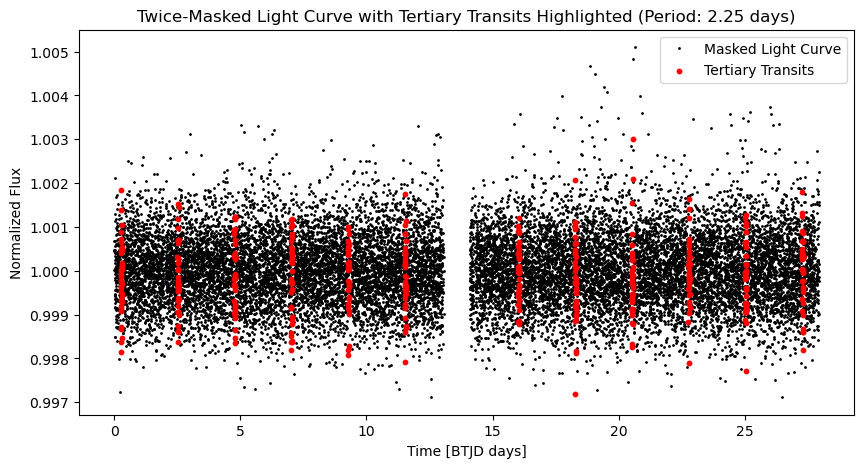

<Figure size 1000x500 with 0 Axes>

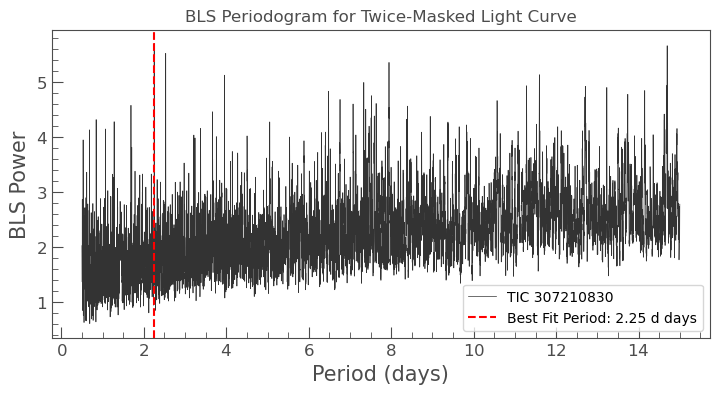

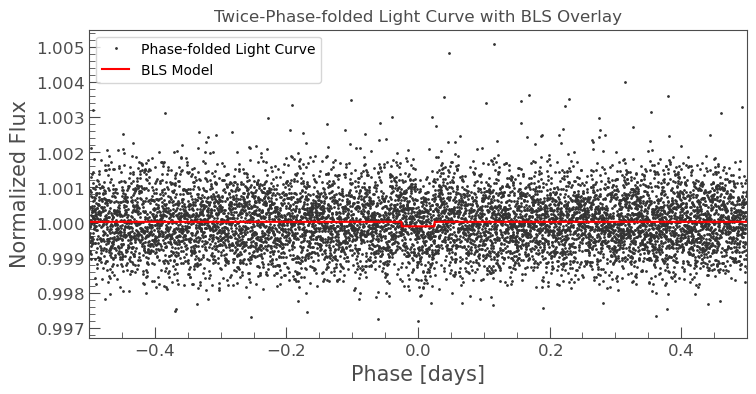

In [171]:
# Mask the primary transit
primary_transit_mask = bls_results.get_transit_mask(period=best_fit_period, transit_time=best_fit_t0, duration=bls_results.duration_at_max_power)
masked_lc_primary = lc[~primary_transit_mask].remove_nans().flatten()

# Recompute the BLS periodogram on the masked light curve to find the second planet
bls_results_secondary = masked_lc_primary.to_periodogram(method='bls', period=np.linspace(0.5, 15, 10000))
best_fit_period_secondary = bls_results_secondary.period_at_max_power
best_fit_t0_secondary = bls_results_secondary.transit_time_at_max_power

# Mask the secondary transit as well
secondary_transit_mask = bls_results_secondary.get_transit_mask(period=best_fit_period_secondary, transit_time=best_fit_t0_secondary, duration=bls_results_secondary.duration_at_max_power)
masked_lc_secondary = masked_lc_primary[~secondary_transit_mask].remove_nans().flatten()

# Recompute the BLS periodogram on the twice-masked light curve to find the third planet
bls_results_tertiary = masked_lc_secondary.to_periodogram(method='bls', period=np.linspace(0.5, 15, 10000))
best_fit_period_tertiary = bls_results_tertiary.period_at_max_power
best_fit_t0_tertiary = bls_results_tertiary.transit_time_at_max_power

# Highlight the tertiary transits on the light curve
tertiary_transit_mask = bls_results_tertiary.get_transit_mask(period=best_fit_period_tertiary, transit_time=best_fit_t0_tertiary, duration=bls_results_tertiary.duration_at_max_power)
plt.figure(figsize=(10, 5))
plt.plot(masked_lc_secondary.time.value, masked_lc_secondary.flux, 'k.', label='Masked Light Curve', linestyle='none', markersize=2)
plt.scatter(masked_lc_secondary.time.value[tertiary_transit_mask], masked_lc_secondary.flux[tertiary_transit_mask], color='red', label='Tertiary Transits', zorder=2, s=10)
plt.legend()
plt.xlabel('Time [BTJD days]')
plt.ylabel('Normalized Flux')
plt.title(f'Twice-Masked Light Curve with Tertiary Transits Highlighted (Period: {best_fit_period_tertiary.value:.2f} days)')
plt.show()

# Plot the BLS periodogram with the tertiary transit indicated
plt.figure(figsize=(10, 5))
bls_results_tertiary.plot()
plt.axvline(x=best_fit_period_tertiary.value, color='r', linestyle='--', label=f'Best Fit Period: {best_fit_period_tertiary:.2f} days')
plt.xlabel('Period (days)')
plt.ylabel('BLS Power')
plt.title('BLS Periodogram for Twice-Masked Light Curve')
plt.legend()
plt.show()

# Plot the phase-folded light curve with BLS overlay for the secondary transit
folded_lc_tertiary = masked_lc_secondary.fold(period=best_fit_period_tertiary.value, epoch_time=best_fit_t0_tertiary.value)
bls_model_tertiary = bls_results_tertiary.get_transit_model(period=best_fit_period_tertiary, transit_time=best_fit_t0_tertiary, duration=bls_results_tertiary.duration_at_max_power)
folded_lc_tertiary.plot(label='Phase-folded Light Curve', marker='.', linestyle='none')
plt.plot(folded_lc_tertiary.time.value, bls_model_tertiary.fold(period=best_fit_period_tertiary, epoch_time=best_fit_t0_tertiary).flux, color='red', label='BLS Model')
plt.legend()
plt.xlabel('Phase [days]')
plt.ylabel('Normalized Flux')
plt.title('Twice-Phase-folded Light Curve with BLS Overlay')
plt.xlim(-.5, .5)
plt.show()

In [172]:
# Calculate the median baseline flux outside of tertiary transits
baseline_flux_tertiary = np.median(folded_lc_tertiary.flux[~tertiary_transit_mask])

# Find the minimum flux during the tertiary transit
transit_flux_tertiary = np.min(folded_lc_tertiary.flux[tertiary_transit_mask])

# Calculate the transit depth as the drop in flux during the transit compared to the baseline
transit_depth_tertiary = (baseline_flux_tertiary - transit_flux_tertiary) / baseline_flux_tertiary

# Convert the transit depth to percentage
transit_depth_pct_tertiary = transit_depth_tertiary * 100

# Print the transit depth for the tertiary planet
print(f"Transit depth for the tertiary planet: {transit_depth_pct_tertiary:.3f}%")


Transit depth for the tertiary planet: 0.262%


In [173]:
from astropy.constants import R_sun, R_jup
import numpy as np

# Sample values, replace these with actual data
transit_depth_pct =  transit_depth_pct_tertiary # transit depth in percent from your phase-folded light curve
star_radius_sol = catalogData['rad'][0]  # Star radius in solar radii
star_radius_error = catalogData['e_rad'][0]  # Error in star radius


# Convert the transit depth from percentage to fraction
transit_depth = transit_depth_pct / 100.0

# Convert star radius from solar radii to meters
star_radius_m = star_radius_sol * R_sun.value

# Calculate the planet radius in meters
planet_radius_m = np.sqrt(transit_depth) * star_radius_m

# Convert the planet radius from meters to Jupiter radii
planet_radius_rj = planet_radius_m / R_jup.value

# Propagate the error from the star's radius to the planet's radius
planet_radius_error = (0.5 * star_radius_error / star_radius_sol) * planet_radius_rj / np.sqrt(transit_depth)

# Print the results
print(f"Estimated radius of the exoplanet: {planet_radius_rj:.3f} Jupiter radii")
print(f"Error in the exoplanet's radius: ±{planet_radius_error:.3f} Jupiter radii")


Estimated radius of the exoplanet: 0.157 Jupiter radii
Error in the exoplanet's radius: ±0.045 Jupiter radii


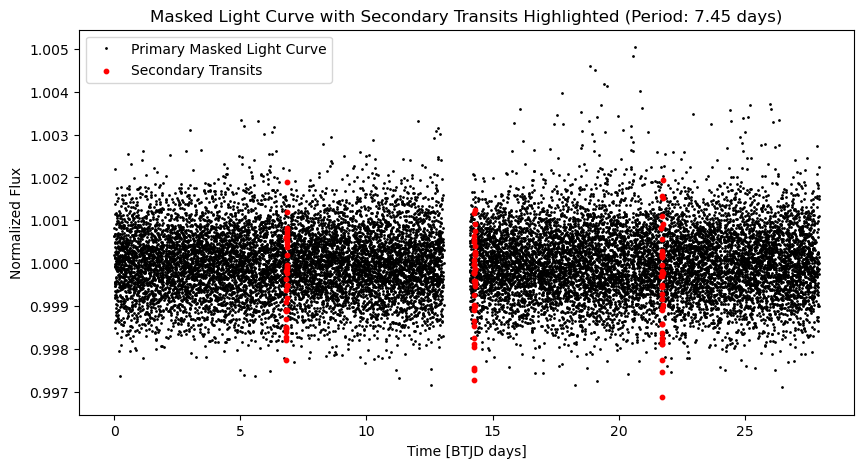

<Figure size 1000x500 with 0 Axes>

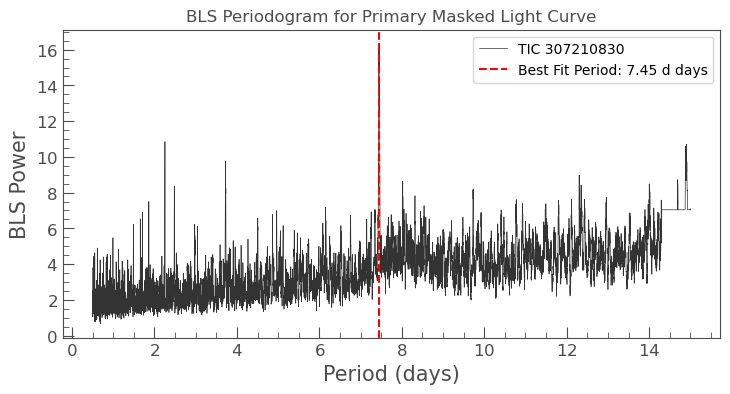

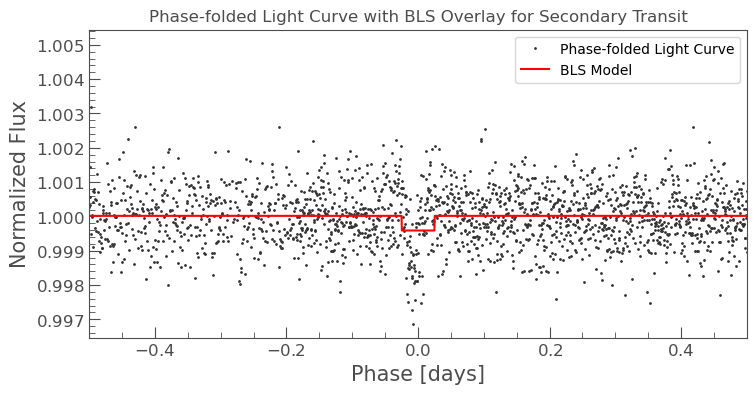

In [174]:
# Mask the primary transit
primary_transit_mask = bls_results.get_transit_mask(period=best_fit_period, transit_time=best_fit_t0, duration=bls_results.duration_at_max_power)
masked_lc_primary = lc[~primary_transit_mask].remove_nans().flatten()

# Recompute the BLS periodogram on the masked light curve to find the secondary planet
bls_results_secondary = masked_lc_primary.to_periodogram(method='bls', period=np.linspace(0.5, 15, 10000))
best_fit_period_secondary = bls_results_secondary.period_at_max_power
best_fit_t0_secondary = bls_results_secondary.transit_time_at_max_power

# Highlight the secondary transits on the light curve
secondary_transit_mask = bls_results_secondary.get_transit_mask(period=best_fit_period_secondary, transit_time=best_fit_t0_secondary, duration=bls_results_secondary.duration_at_max_power)
plt.figure(figsize=(10, 5))
plt.plot(masked_lc_primary.time.value, masked_lc_primary.flux, 'k.', label='Primary Masked Light Curve', linestyle='none', markersize=2)
plt.scatter(masked_lc_primary.time.value[secondary_transit_mask], masked_lc_primary.flux[secondary_transit_mask], color='red', label='Secondary Transits', zorder=2, s=10)
plt.legend()
plt.xlabel('Time [BTJD days]')
plt.ylabel('Normalized Flux')
plt.title(f'Masked Light Curve with Secondary Transits Highlighted (Period: {best_fit_period_secondary.value:.2f} days)')
plt.show()

# Plot the BLS periodogram with the secondary transit indicated
plt.figure(figsize=(10, 5))
bls_results_secondary.plot()
plt.axvline(x=best_fit_period_secondary.value, color='r', linestyle='--', label=f'Best Fit Period: {best_fit_period_secondary:.2f} days')
plt.xlabel('Period (days)')
plt.ylabel('BLS Power')
plt.title('BLS Periodogram for Primary Masked Light Curve')
plt.legend()
plt.show()

# Plot the phase-folded light curve with BLS overlay for the secondary transit
folded_lc_secondary = masked_lc_primary.fold(period=best_fit_period_secondary.value, epoch_time=best_fit_t0_secondary.value)
bls_model_secondary = bls_results_secondary.get_transit_model(period=best_fit_period_secondary, transit_time=best_fit_t0_secondary, duration=bls_results_secondary.duration_at_max_power)
folded_lc_secondary.plot(label='Phase-folded Light Curve', marker='.', linestyle='none')
plt.plot(folded_lc_secondary.time.value, bls_model_secondary.fold(period=best_fit_period_secondary, epoch_time=best_fit_t0_secondary).flux, color='red', label='BLS Model')
plt.legend()
plt.xlabel('Phase [days]')
plt.ylabel('Normalized Flux')
plt.title('Phase-folded Light Curve with BLS Overlay for Secondary Transit')
plt.xlim(-.5, .5)
plt.show()


In [175]:
# Code to calculate the transit depth for the secondary planet candidate
# Assuming you have folded_lc_secondary and secondary_transit_mask from the phase-folded light curve of the secondary planet

# Find the out-of-transit baseline flux level
baseline_flux_secondary = np.median(folded_lc_secondary.flux[~secondary_transit_mask])

# Find the flux at the minimum point of the transit
transit_flux_secondary = np.min(folded_lc_secondary.flux[secondary_transit_mask])

# Calculate the transit depth for the secondary planet
transit_depth_secondary = (baseline_flux_secondary - transit_flux_secondary) / baseline_flux_secondary

# Express the transit depth in percentage
transit_depth_pct_secondary = transit_depth_secondary * 100

# Print the transit depth for the secondary planet
print(f"Transit depth for the secondary planet: {transit_depth_pct_secondary:.3f}%")


Transit depth for the secondary planet: 0.156%


In [176]:
import numpy as np
import lightkurve as lk

# Assuming you have already found the primary planet and created a mask for it
primary_transit_mask = bls_results.get_transit_mask(period=best_fit_period, 
                                                    transit_time=best_fit_t0, 
                                                    duration=bls_results.duration_at_max_power)

# Mask the primary transit from the original light curve
masked_lc = lc[~primary_transit_mask].remove_nans().flatten()

# Define the number of bootstrap iterations
num_bootstrap_iterations = 10  # Adjust as needed for robust statistics

# Arrays to store the bootstrap results for the secondary signal
bootstrap_periods_secondary = []
bootstrap_durations_hours_secondary = []  # Store durations in hours for the secondary signal

# Conduct the bootstrap resampling on the masked light curve
for i in range(num_bootstrap_iterations):
    # Randomly select data points with replacement to create a bootstrap sample from the masked light curve
    indices = np.random.choice(len(masked_lc.time.value), len(masked_lc.time.value))
    bootstrap_lc_secondary = lk.LightCurve(time=masked_lc.time.value[indices], flux=masked_lc.flux.value[indices])

    # Perform BLS analysis on the resampled masked light curve
    bls_results_bootstrap_secondary = bootstrap_lc_secondary.to_periodogram(method='bls', period=np.linspace(0.5, 50, 10000))
    
    # Store the period from each bootstrap iteration for the secondary signal
    bootstrap_periods_secondary.append(bls_results_bootstrap_secondary.period_at_max_power.value)
    
    # Store the duration in hours for the secondary signal
    bootstrap_durations_hours_secondary.append(bls_results_bootstrap_secondary.duration_at_max_power.value * 24)  # Convert days to hours

# Calculate the standard deviations of the results as the uncertainties for the secondary signal
period_error_secondary = np.std(bootstrap_periods_secondary)
duration_error_hours_secondary = np.std(bootstrap_durations_hours_secondary)  # Uncertainty in hours for the secondary signal

# Report the results with calculated uncertainties for the secondary signal
print(f"Period for the secondary planet: {np.mean(bootstrap_periods_secondary):.6f} ± {period_error_secondary:.6f} days")
print(f"Transit Duration for the secondary planet: {np.mean(bootstrap_durations_hours_secondary):.6f} ± {duration_error_hours_secondary:.6f} hours")



Period for the secondary planet: 7.513861 ± 7.137461 days
Transit Duration for the secondary planet: 3.216000 ± 3.079491 hours


In [177]:
from astropy.constants import R_sun, R_jup
import numpy as np

# Assuming transit_depth_pct is the transit depth in percentage from the phase-folded and masked light curve
transit_depth = transit_depth_pct_secondary 

# Assuming 'catalogData' is the result from the TIC catalog query.
# Replace 'catalogData' with your actual data
star_radius_sol = catalogData['rad'][0]  # Star radius in solar radii
star_radius_error = catalogData['e_rad'][0]  # Error in star radius

# Convert star radius from solar radii to meters
star_radius_m = star_radius_sol * R_sun.value

# The transit depth is the square of the planet-to-star radius ratio
planet_radius_m = np.sqrt(transit_depth) * star_radius_m

# Convert the planet's radius from meters to Jupiter radii
planet_radius_rj = planet_radius_m / R_jup.value

# Calculate the error in the planet's radius
# Note: This propagation of error assumes that the transit depth error is negligible compared to the star's radius error
planet_radius_error_rj = planet_radius_rj * (0.5 * star_radius_error / star_radius_sol) / np.sqrt(transit_depth)

# Print the estimated radius of the exoplanet and its error
print(f"Estimated radius of the exoplanet: {planet_radius_rj:.3f} Jupiter radii")
print(f"Error in the exoplanet's radius: ±{planet_radius_error_rj:.3f} Jupiter radii")


Estimated radius of the exoplanet: 1.208 Jupiter radii
Error in the exoplanet's radius: ±0.045 Jupiter radii


Period for the tertiary planet: 7.336634 ± 5.682272 days
Transit Duration for the tertiary planet: 2.664000 ± 2.651864 hours
